## Importation des librairies et du dataset

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools

In [2]:
fichier_inverse = pd.read_csv("../csv_docs/fichier_inverse.csv")
fichier_inverse = fichier_inverse.drop("Unnamed: 0", axis=1) # "Unnamed: 0" : indexes de préparation des données
fichier_inverse

,Word,Document,Frequence,Poid
0,0,D443,1,0.210977
1,0.18,D1090,1,0.527442
2,0.5,D720,1,0.791163
3,0.7%,D691,1,0.395581
4,000,D687,2,1.071347
...,...,...,...,...
77177,zipfian,D329,1,0.527442
77178,zone,D62,2,0.575391
77179,zoolog,D755,1,0.632930
77180,zuckerman,D1291,1,1.431959


In [13]:
len(fichier_inverse["Word"].unique())

6929

In [14]:
fichier_inverse["Frequence"].unique()

array([ 1,  2,  3,  4,  6,  5, 10,  9, 13, 12,  7, 11,  8, 14, 27, 15],
      dtype=int64)

In [7]:
info_queries = pd.read_csv("../csv_docs/info_queries.csv")
info_queries = info_queries.drop("Unnamed: 0", axis=1)
info_queries

,Query,Word
0,Q1,problem
1,Q1,concern
2,Q1,make
3,Q1,descript
4,Q1,titl
...,...,...
5188,Q112,algorithm
5189,Q112,compar
5190,Q112,previous
5191,Q112,describ


In [11]:
list(info_queries[info_queries["Query"]=="Q1"]["Word"])

['problem',
 'concern',
 'make',
 'descript',
 'titl',
 'difficulti',
 'involv',
 'automat',
 'retriev',
 'articl',
 'approxim',
 'titl',
 'usual',
 'relev',
 'content',
 'articl',
 'titl']

### SRI basé sur le modèle vectoriel avec la fonction Scalar Product

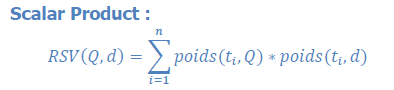

In [8]:
# SRI Vectoriel (Scalar Product)
def scalar_product(query,fichier_inverse,info_queries):
    words = list(info_queries.loc[info_queries["Query"] == query, "Word"].unique()) # liste des mots de la requête
    sri = fichier_inverse.loc[fichier_inverse["Word"].isin(words),["Document","Poid"]] # on récupère les documents et les poids des mots de la requête
    sri = sri.groupby('Document')['Poid'].sum().to_frame() # on somme les poids des mots de la requête
    # reset_index() method sets a list of integer ranging from 0 to length of data as index usually used after groupby method.
    sri.reset_index(inplace=True) # on remet les documents en colonne
    sri.rename(columns = {'Poid':'RSV'}, inplace = True) # on renomme la colonne
    sri = sri.sort_values(by=["RSV"]) # on trie les documents par poids
    return sri.reindex(index=sri.index[::-1]) # on inverse l'ordre des documents

scalar_product("Q1", fichier_inverse, info_queries).head(10).style.set_caption("documents relative au Q1 dans l'ordre de pertinance :")

,Document,RSV
571,D451,2.291059
894,D814,2.223797
543,D42,2.127047
261,D1364,1.971921
275,D1388,1.949736
900,D820,1.945163
552,D429,1.939478
564,D445,1.896390
845,D759,1.889621
755,D650,1.864368


### SRI basé sur le modèle vectoriel avec la fonction Cosine Measure

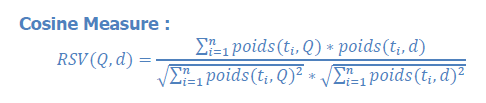

In [12]:
# SRI Vectoriel (Cosine Measure)
def cosine_measure(query,fichier_inverse,info_queries):
    # calcule de partie Numérateur de la formule pour tous les documents
    words = list(info_queries.loc[info_queries["Query"] == query, "Word"].unique()) # liste des mots de la requête
    df = fichier_inverse.loc[fichier_inverse["Word"].isin(words),["Document","Word","Poid"]] # on récupère les documents et les poids des mots de la requête
    n = df.groupby('Document')['Word'].count().to_frame() # on compte le nombre de mots par document
    df = df.groupby('Document')['Poid'].sum().to_frame() # on somme les poids des mots de la requête
    df.reset_index(inplace=True) # on remet les documents en colonne
    df.rename(columns = {'Poid':'Scalar weight'}, inplace = True)  # on renomme la colonne

    # calcule de partie dénominateur de la formule pour tous les documents
    df["SQRT weight query"] = np.sqrt(n).to_numpy() # on calcule la racine carrée du nombre de mots par document

    sqrt_weights_doc = fichier_inverse.copy() # on copie le fichier inverse
    sqrt_weights_doc["Poid"] = np.power(sqrt_weights_doc["Poid"], 2) # on calcule le carré des poids
    sqrt_weights_doc = sqrt_weights_doc.groupby('Document')['Poid'].sum().to_frame() # on somme les carrés des poids
    sqrt_weights_doc["Poid"] = np.sqrt(sqrt_weights_doc["Poid"]) # on calcule la racine carrée des sommes des carrés des poids
    sqrt_weights_doc.rename(columns = {'Poid':'SQRT weight doc'}, inplace = True) # on renomme la colonne
    df = df.merge(sqrt_weights_doc, on="Document") # on fusionne les deux dataframes

    # le resultat de la formule
    df["RSV"] = np.divide( # on divise le poids de la requête par le produit des racines carrées des poids de la requête et du document
                            df["Scalar weight"], 
                            np.multiply(df["SQRT weight query"], df["SQRT weight doc"]))

    df = df[["Document", "RSV"]].sort_values(by=["RSV"]) # on trie les documents par poids (ordre croissant par defaut)
    return df.reindex(index=df.index[::-1]) # on inverse l'ordre des documents

cosine_measure("Q1", fichier_inverse, info_queries) 

,Document,RSV
568,D449,0.529178
677,D565,0.488123
457,D315,0.475616
563,D444,0.472281
213,D1281,0.452538
...,...,...
30,D1039,0.028411
966,D903,0.024858
28,D1037,0.024400
528,D400,0.020878


### SRI basé sur le modèle vectoriel avec la fonction Jaccard Measure

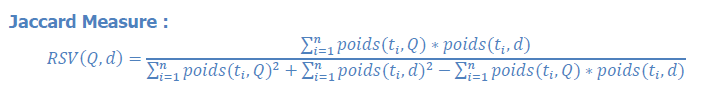

In [13]:
# SRI Vectoriel (Jaccard Measure)
def jaccard_measure(query,fichier_inverse,info_queries):
    # calcule de partie Numérateur de la formule pour tous les documents
    words = list(info_queries.loc[info_queries["Query"] == query, "Word"]) # liste des mots de la requête
    df = fichier_inverse.loc[fichier_inverse["Word"].isin(words),["Document","Word","Poid"]] # on récupère les documents et les poids des mots de la requête
    n = df.groupby('Document')['Word'].count().to_frame() # on compte le nombre de mots par document
    df = df.groupby('Document')['Poid'].sum().to_frame() # on somme les poids des mots de la requête
    df.reset_index(inplace=True) # on remet les documents en colonne
    df.rename(columns = {'Poid':'Scalar weight'}, inplace = True) # on renomme la colonne
    
    # calcule de partie Dénumérateur de la formule pour tous les documents
    df["square weight query"] = n.to_numpy() # on calcule le carré du nombre de mots par document

    square_weights_doc = fichier_inverse.copy() # on copie le fichier inverse
    square_weights_doc["Poid"] = np.power(square_weights_doc["Poid"], 2) # on calcule le carré des poids
    square_weights_doc = square_weights_doc.groupby('Document')['Poid'].sum().to_frame() # on somme les carrés des poids
    square_weights_doc.rename(columns = {'Poid':'square weight doc'}, inplace = True) # on renomme la colonne
    df = df.merge(square_weights_doc, on="Document") # on fusionne les deux dataframes

    df["RSV"] = np.divide(# on divise le poids de la requête par la différence des sommes des carrés des poids de la requête et du document
                            df["Scalar weight"], 
                            np.subtract(np.add(df["square weight query"], df["square weight doc"]), 
                                                df["Scalar weight"]))

    df = df[["Document", "RSV"]].sort_values(by=["RSV"]) # on trie les documents par poids
    return df.reindex(index=df.index[::-1]) # on inverse l'ordre des documents

jaccard_measure("Q1", fichier_inverse, info_queries)

,Document,RSV
568,D449,0.339517
457,D315,0.309393
677,D565,0.299543
820,D722,0.276014
213,D1281,0.262324
...,...,...
350,D173,0.004599
179,D1234,0.004437
528,D400,0.004202
412,D248,0.003973


## Evaluation des SRI vectorielle

### importation des documents pertinents donnée par l'environement de teste

In [9]:
def load_rel():
    path ='../cisi/CISI.REL'
    with open(path) as f:
        rel_set = {}
        for l in f.readlines():
            qry_id = int(l.lstrip(" ").strip(
                "\n").split("\t")[0].split(" ")[0])
            doc_id = int(l.lstrip(" ").strip(
                "\n").split("\t")[0].split(" ")[-1])
            qry_id= f"Q{qry_id}"
            doc_id= f"D{doc_id}"
            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)
    return rel_set
rel = load_rel()
dict(itertools.islice(rel.items(), 1))

{'Q1': ['D28',
  'D35',
  'D38',
  'D42',
  'D43',
  'D52',
  'D65',
  'D76',
  'D86',
  'D150',
  'D189',
  'D192',
  'D193',
  'D195',
  'D215',
  'D269',
  'D291',
  'D320',
  'D429',
  'D465',
  'D466',
  'D482',
  'D483',
  'D510',
  'D524',
  'D541',
  'D576',
  'D582',
  'D589',
  'D603',
  'D650',
  'D680',
  'D711',
  'D722',
  'D726',
  'D783',
  'D813',
  'D820',
  'D868',
  'D869',
  'D894',
  'D1162',
  'D1164',
  'D1195',
  'D1196',
  'D1281']}

In [10]:
# cette fonction retourne les measures de performance
def evaluation(function,fichier_inverse,info_queries,rel,sueil=None):
    data=[] # contiendra les mesures de performance avec tout les requetes
    for qr in rel.keys():
        if sueil is None:
            # selectioner les n premier elements tel que n = nombre des document relative au requete 
            docPert = function(qr, fichier_inverse, info_queries).head(len(rel[qr])) 
        else:
            docPert = function(qr, fichier_inverse, info_queries)          
            docPert = docPert[docPert["RSV"]>sueil] # filtrer avec similarité supèrieur au suiel
        if len(docPert["Document"])>0:
            # summary contient les mesures d'une requete
            summary=[qr]
            precision = sum([doc in rel[qr] for doc in docPert["Document"]])/len(docPert["Document"]) 
            summary.append(precision)
            Pat5 = sum([doc in rel[qr] for doc in docPert["Document"]][0:5])/5
            summary.append(Pat5)
            Pat10 = sum([doc in rel[qr] for doc in docPert["Document"]][0:10])/10
            summary.append(Pat10)
            rappel= sum([doc in rel[qr] for doc in docPert["Document"]])/len(rel[qr]) 
            summary.append(rappel) 
            if precision*rappel !=0:
                Fmesure= (2*precision*rappel)/(precision+rappel)
            else: 
                Fmesure=0
            summary.append(Fmesure)
            data.append(summary)
    return pd.DataFrame(data, columns = ["Query","Precision","𝑃@5","𝑃@10","Rappel","F-mesure"])

### Evaluation du systeme SRI basé sur la fonction Scalar Product 

In [11]:
# moyennes des mesures dans le cas ou #𝒕𝒐𝒕𝒂𝒍 𝒅𝒆 𝒅𝒐𝒄𝒖𝒎𝒆𝒏𝒕𝒔 𝒔é𝒍𝒆𝒄𝒕𝒊𝒐𝒏𝒏é𝒔=#𝒕𝒐𝒕𝒂𝒍 𝒅𝒆 𝒅𝒐𝒄𝒖𝒎𝒆𝒏𝒕𝒔 𝒑𝒆𝒓𝒕𝒊𝒏𝒆𝒏𝒕𝒔
scalar_product_evaluation= evaluation(scalar_product,fichier_inverse,info_queries,rel)
scalar_product_evaluation.drop("Query",axis=1).mean() 

Precision    0.179901
𝑃@5          0.300000
𝑃@10         0.260526
Rappel       0.179901
F-mesure     0.179901
dtype: float64

In [12]:
seuil =0.5
data=[]
while seuil<2:
    summary=[seuil]
    scalar_pro_evaluation= evaluation(scalar_product,fichier_inverse,info_queries,rel,seuil)
    summary.extend(list(scalar_pro_evaluation.drop("Query",axis=1).mean())) # ajouter les moyenne des measures avec les suiel corrant
    data.append(summary)
    seuil+=0.1
scalar_product_evaluation_resume = pd.DataFrame(data, columns = ["seuil","moyPrecision","moy𝑃@5","moy𝑃@10","moyRappel","moyF-mesure"])
scalar_product_evaluation_resume

,seuil,moyPrecision,moy𝑃@5,moy𝑃@10,moyRappel,moyF-mesure
0,0.5,0.053705,0.300000,0.265789,0.806587,0.093639
1,0.6,0.065790,0.300000,0.265789,0.761360,0.107250
2,0.7,0.072590,0.300000,0.265789,0.719297,0.114033
3,0.8,0.082734,0.300000,0.265789,0.672502,0.122249
4,0.9,0.091168,0.300000,0.265789,0.626669,0.126724
5,1.0,0.101087,0.300000,0.265789,0.590228,0.131000
6,1.1,0.110020,0.300000,0.265789,0.546812,0.130123
7,1.2,0.117591,0.300000,0.265789,0.510391,0.129157
8,1.3,0.128116,0.300000,0.265789,0.478104,0.128295
9,1.4,0.138582,0.300000,0.261842,0.447524,0.126952


* meilleur suiel avec la methode "scalar product" c'est : 1.0  (en se basant sur le f-measure)

In [13]:
scalar_product_evaluation= evaluation(scalar_product,fichier_inverse,info_queries,rel,1.0)
scalar_product_evaluation

,Query,Precision,𝑃@5,𝑃@10,Rappel,F-mesure
0,Q1,0.171233,0.2,0.4,0.543478,0.260417
1,Q2,0.037500,0.0,0.1,0.230769,0.064516
2,Q3,0.441176,0.8,0.7,0.340909,0.384615
3,Q4,0.089286,0.2,0.2,0.625000,0.156250
4,Q5,0.039216,0.4,0.3,0.500000,0.072727
...,...,...,...,...,...,...
71,Q101,0.001272,0.0,0.0,1.000000,0.002541
72,Q102,0.030457,0.4,0.3,1.000000,0.059113
73,Q104,0.016100,0.0,0.0,0.818182,0.031579
74,Q109,0.059503,0.6,0.7,0.943662,0.111947


#### Trace de courbe Rappel-precision

In [14]:
def get_RapPrec_Points(function,fichier_inverse, info_queries,rel):
    q = "Q3" # prendre la requete Q3 comme donnée de teste
    nb_doc_pertinent= 10  # le nombre de document pertinents dans rel on prend 10 mais en vrai ce sont 44
    # prendre les 10 premier elements dans l'ordre de similarité comme document sélectionées
    result = function(q, fichier_inverse, info_queries).head(nb_doc_pertinent)
    result['pertinent'] = result['Document'].apply(lambda x: True if x in rel[q] else False)
    RP= []
    for i in range(len(result['pertinent'])):
        row=[]
        if result['pertinent'].iloc[i]== True:
            rappel= (i+1)/nb_doc_pertinent    # formule de rappel
            row.append(rappel)
            pecision = (len(RP)+1)/(i+1)    # formule de precision
            row.append(pecision)
            RP.append(row)
    print(result)
    return pd.DataFrame(RP, columns = ["Rappel","Precision"])

In [15]:
RP = get_RapPrec_Points(scalar_product,fichier_inverse, info_queries,rel)

    Document       RSV  pertinent
142    D1181  2.842382       True
174    D1235  2.149689      False
139    D1179  2.089300       True
509     D445  1.955432       True
528     D469  1.639858       True
831     D898  1.614960      False
178    D1241  1.475971      False
636     D599  1.454757       True
131    D1169  1.446902       True
595     D553  1.344830       True


In [28]:
from math import isnan
print(RP)
data=[]
for i in range(11):
    R= i/10
    row=[R]
    P = np.max(RP['Precision'][RP['Rappel'].apply(lambda x: True if x >= R else False)])
    if isnan(P):
        row.append(0)
    else:
        row.append(P)
    data.append(row)
NormalizedRP = pd.DataFrame(data, columns = ["Rappel","Precision"])
NormalizedRP

   Rappel  Precision
0     0.1   1.000000
1     0.3   0.666667
2     0.4   0.750000
3     0.5   0.800000
4     0.8   0.625000
5     0.9   0.666667
6     1.0   0.700000


,Rappel,Precision
0,0.0,1.0
1,0.1,1.0
2,0.2,0.8
3,0.3,0.8
4,0.4,0.8
5,0.5,0.8
6,0.6,0.7
7,0.7,0.7
8,0.8,0.7
9,0.9,0.7


   Rappel  Precision
0     0.1   1.000000
1     0.3   0.666667
2     0.4   0.750000
3     0.5   0.800000
4     0.8   0.625000
5     0.9   0.666667
6     1.0   0.700000


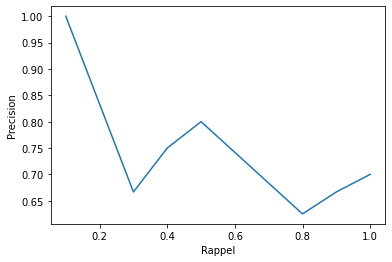

In [136]:
# Courbe rappel/précision pour une requête à chaque document pertinent
print(RP)
plt.plot(RP["Rappel"], RP["Precision"])
plt.xlabel('Rappel')
plt.ylabel('Precision')
plt.show()

### Evaluation du systeme SRI basé sur la fonction Cosine Measure

In [88]:
seuil =0.1
data=[]
while seuil<0.5:
    summary=[seuil]
    cosine_mesure_evaluation= evaluation(cosine_measure,fichier_inverse,info_queries,rel,seuil)
    summary.extend(list(cosine_mesure_evaluation.drop("Query",axis=1).mean())) # ajouter les moyenne des measures avec les suiel corrant
    data.append(summary)
    seuil+=0.05
cosine_mesure_evaluation_resume = pd.DataFrame(data, columns = ["seuil","moyPrecision","moy𝑃@5","moy𝑃@10","moyRappel","moyF-mesure"])
cosine_mesure_evaluation_resume

,seuil,moyPrecision,moy𝑃@5,moy𝑃@10,moyRappel,moyF-mesure
0,0.10,0.050279,0.207895,0.201316,0.820799,0.089200
1,0.15,0.064927,0.207895,0.201316,0.683667,0.107663
2,0.20,0.084296,0.207895,0.201316,0.522040,0.124796
3,0.25,0.103987,0.207895,0.201316,0.383709,0.129166
4,0.30,0.129948,0.207895,0.201316,0.274440,0.125663
5,0.35,0.158869,0.207895,0.200000,0.184368,0.112100
6,0.40,0.193176,0.205263,0.180263,0.101200,0.090212
7,0.45,0.210724,0.175676,0.127027,0.058566,0.067651
8,0.50,0.224352,0.125000,0.081250,0.032953,0.048888


* meilleur suiel avec la methode "cosine" c'est : 0.25 (en se basant sur le f-measure)

In [90]:
cosine_measure_evaluation= evaluation(cosine_measure,fichier_inverse,info_queries,rel,0.25)
cosine_measure_evaluation

,Query,Precision,𝑃@5,𝑃@10,Rappel,F-mesure
0,Q1,0.148148,0.2,0.2,0.260870,0.188976
1,Q2,0.032609,0.0,0.0,0.115385,0.050847
2,Q3,0.309524,0.6,0.6,0.295455,0.302326
3,Q4,0.078947,0.2,0.1,0.375000,0.130435
4,Q5,0.032258,0.0,0.0,0.125000,0.051282
...,...,...,...,...,...,...
71,Q101,0.004115,0.0,0.0,1.000000,0.008197
72,Q102,0.071174,0.2,0.3,0.833333,0.131148
73,Q104,0.041667,0.0,0.0,0.727273,0.078818
74,Q109,0.098947,0.4,0.5,0.661972,0.172161


#### Trace de courbe Rappel-precision

In [131]:
RP = get_RapPrec_Points(cosine_measure,fichier_inverse, info_queries,rel)

    Document       RSV  pertinent
528     D469  0.637261       True
18     D1030  0.490082      False
509     D445  0.417954       True
518     D456  0.398185      False
811      D85  0.396736       True
636     D599  0.389704       True
108    D1142  0.375598      False
638      D60  0.375082       True
581     D535  0.363331      False
673     D640  0.352652       True


   Rappel  Precision
0     0.1   1.000000
1     0.3   0.666667
2     0.5   0.600000
3     0.6   0.666667
4     0.8   0.625000
5     1.0   0.600000


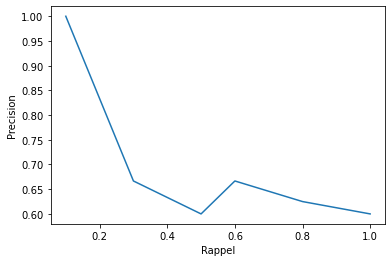

In [132]:
# Courbe rappel/précision pour une requête à chaque document pertinent
print(RP)
plt.plot(RP["Rappel"], RP["Precision"])
plt.xlabel('Rappel')
plt.ylabel('Precision')
plt.show()

### Evaluation du systeme SRI basé sur la fonction Jaccard Measure

In [89]:
seuil =0.02
data=[]
while seuil<0.3:
    summary=[seuil]
    jaccard_mesure_evaluation= evaluation(jaccard_measure,fichier_inverse,info_queries,rel,seuil)
    summary.extend(list(jaccard_mesure_evaluation.drop("Query",axis=1).mean())) # ajouter les moyenne des measures avec les suiel corrant
    data.append(summary)
    seuil+=0.02
jaccard_mesure_evaluation_resume = pd.DataFrame(data, columns = ["seuil","moyPrecision","moy𝑃@5","moy𝑃@10","moyRappel","moyF-mesure"])
jaccard_mesure_evaluation_resume

,seuil,moyPrecision,moy𝑃@5,moy𝑃@10,moyRappel,moyF-mesure
0,0.02,0.042657,0.215789,0.196053,0.897361,0.077899
1,0.04,0.054029,0.215789,0.196053,0.786925,0.093886
2,0.06,0.064478,0.215789,0.196053,0.664290,0.105773
3,0.08,0.075981,0.215789,0.196053,0.569765,0.115462
4,0.10,0.089604,0.215789,0.196053,0.475438,0.123042
5,0.12,0.103402,0.215789,0.196053,0.394017,0.125549
6,0.14,0.113861,0.215789,0.196053,0.323370,0.120996
7,0.16,0.130128,0.215789,0.196053,0.274397,0.121047
8,0.18,0.141084,0.215789,0.196053,0.223337,0.112873
9,0.20,0.166399,0.215789,0.188158,0.176885,0.105595


* meilleur suiel avec la methode "jaccard" c'est : 0.12 (en se basant sur le f-measure)

In [91]:
jaccard_measure_evaluation= evaluation(jaccard_measure,fichier_inverse,info_queries,rel,0.12)
jaccard_measure_evaluation

,Query,Precision,𝑃@5,𝑃@10,Rappel,F-mesure
0,Q1,0.152542,0.4,0.4,0.195652,0.171429
1,Q2,0.045977,0.0,0.1,0.153846,0.070796
2,Q3,0.358974,0.6,0.4,0.318182,0.337349
3,Q4,0.107143,0.2,0.1,0.375000,0.166667
4,Q5,0.026549,0.0,0.0,0.125000,0.043796
...,...,...,...,...,...,...
71,Q101,0.002959,0.0,0.0,1.000000,0.005900
72,Q102,0.059880,0.2,0.3,0.833333,0.111732
73,Q104,0.037383,0.0,0.0,0.727273,0.071111
74,Q109,0.085366,0.8,0.6,0.690141,0.151938


#### Trace de courbe Rappel-precision

In [133]:
RP = get_RapPrec_Points(jaccard_measure,fichier_inverse, info_queries,rel)

    Document       RSV  pertinent
528     D469  0.459677       True
18     D1030  0.282168      False
811      D85  0.246647       True
518     D456  0.235202      False
636     D599  0.235007       True
108    D1142  0.230572      False
581     D535  0.219951      False
214    D1297  0.198352      False
638      D60  0.194439       True
92     D1125  0.193389      False


   Rappel  Precision
0     0.1   1.000000
1     0.3   0.666667
2     0.5   0.600000
3     0.9   0.444444


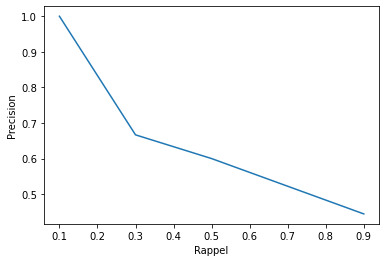

In [134]:
# Courbe rappel/précision pour une requête à chaque document pertinent
print(RP)
plt.plot(RP["Rappel"], RP["Precision"])
plt.xlabel('Rappel')
plt.ylabel('Precision')
plt.show()